In [1]:
# 由于要实现的模型涉及到比较复杂的数据处理和分析，我们将从简单的数据探索开始，
# 然后尝试定义并计算动量指标，最后进行简单的可视化展示。
# 本例将重点放在如何根据比赛分数计算动量，并不会构建一个完整的状态空间模型。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


In [2]:
# 改进势头计算函数以包括赢得的局数和盘数，以及更精确的发球优势计算
def calculate_momentum_improved_1(df, index, window_size=3):
    start_index = max(index - window_size, 0)
    end_index = min(index + window_size + 1, len(df))
    time_window_df = df.iloc[start_index:end_index]

    # 初始化势头值
    p1_momentum = 0
    p2_momentum = 0

    # 赢得的局数和盘数
    p1_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]
    p1_games_won = time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0]
    p2_games_won = time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0]

    # 发球优势
    # 假设发球方在每个得分上的额外权重为0.1
    serve_advantage_weight = 0.1
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    # 其他因素（得分优势、破发点、非受迫性失误、制胜分）
    p1_points_advantage = time_window_df['point_victor'].apply(lambda x: x == 1).sum() - time_window_df['point_victor'].apply(lambda x: x == 2).sum()
    p2_points_advantage = -p1_points_advantage
    p1_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_break_points_won = time_window_df['p2_break_pt_won'].sum()
    p1_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_unforced_errors = -time_window_df['p2_unf_err'].sum()
    p1_winners = time_window_df['p1_winner'].sum()
    p2_winners = time_window_df['p2_winner'].sum()

    # 合并计算势头
    p1_momentum = p1_points_advantage + p1_serve_advantage + p1_break_points_won + p1_unforced_errors + p1_winners + p1_sets_won + p1_games_won
    #p2_momentum = p2_points_advantage + p2_serve_advantage + p2_break_points_won + p2_unforced_errors + p2_winners + p2_sets_won + p2_games_won

    return p1_points_advantage, p1_serve_advantage, p1_break_points_won, p1_unforced_errors, p1_winners , p1_sets_won, p1_games_won








# 改进势头计算函数以包括赢得的局数和盘数，以及更精确的发球优势计算
def calculate_momentum_improved_2(df, index, window_size=3):
    start_index = max(index - window_size, 0)
    end_index = min(index + window_size + 1, len(df))
    time_window_df = df.iloc[start_index:end_index]

    # 初始化势头值
    p1_momentum = 0
    p2_momentum = 0

    # 赢得的局数和盘数
    p1_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]
    p1_games_won = time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0]
    p2_games_won = time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0]

    # 发球优势
    # 假设发球方在每个得分上的额外权重为0.1
    serve_advantage_weight = 0.1
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    # 其他因素（得分优势、破发点、非受迫性失误、制胜分）
    p1_points_advantage = time_window_df['point_victor'].apply(lambda x: x == 1).sum() - time_window_df['point_victor'].apply(lambda x: x == 2).sum()
    p2_points_advantage = -p1_points_advantage
    p1_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_break_points_won = time_window_df['p2_break_pt_won'].sum()
    p1_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_unforced_errors = -time_window_df['p2_unf_err'].sum()
    p1_winners = time_window_df['p1_winner'].sum()
    p2_winners = time_window_df['p2_winner'].sum()


    return p2_points_advantage, p2_serve_advantage, p2_break_points_won, p2_unforced_errors, p2_winners , p2_sets_won, p2_games_won






def cumsum_detection(series):
    """
    CUMSUM检测算法实现，用于检测序列中的转折点。
    :param series: 一维数据序列 (Pandas Series)
    :return: 转折点的索引列表
    """
    # 计算差分序列
    diff_series = series.diff().fillna(0)  # 用0填充NaN值
    
    # 计算累积和
    cumsum_series = diff_series.cumsum()
    
    # 识别转折点：当累积和重新穿过零点时，认为是一个转折点
    turning_points = []
    for i in range(1, len(cumsum_series)):
        # 如果累积和的符号与前一个不同，则认为是转折点
        if cumsum_series[i] * cumsum_series[i-1] < 0:
            turning_points.append(i)
    
    return turning_points
import numpy as np

def entropy_weight_method(data):
    """
    熵权法计算各指标的权重
    :param data: DataFrame, 各指标的数据
    :return: 权重数组
    """
    # 数据标准化处理
    data_normalized = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    
    # 计算每个指标的熵值
    epsilon = 1e-12  # 避免log(0)
    p_matrix = data_normalized / data_normalized.sum()
    e_matrix = -np.sum(p_matrix * np.log(p_matrix + epsilon), axis=0) / np.log(len(data))
    
    # 计算每个指标的差异系数
    d_matrix = 1 - e_matrix
    
    # 计算权重
    weights = d_matrix / d_matrix.sum()
    
    return weights


In [3]:
# 读取数据
df = pd.read_csv('Wimbledon_featured_matches.csv')

In [4]:


# 选择一场特定的比赛进行分析，根据题目描述选择2023年温布尔登决赛
# 假设决赛的match_id为"2023-wimbledon-1701"

dddd=pd.DataFrame()
for match_id in df['match_id'].unique():
#     match_id = "2023-wimbledon-1701"
    match_data = df[df['match_id'] == match_id].copy()
    match_data.reset_index(inplace=True,drop=True)
    # 对数据集中的每一行应用计算势头的函数
    momentum_values1 = [calculate_momentum_improved_1(match_data, index) for index in range(len(match_data))]
    
    player1_data=pd.DataFrame(momentum_values1,columns=['p1_points_advantage','p1_serve_advantage',
                                     'p1_break_points_won','p1_unforced_errors',
                                     'p1_winners','p1_sets_won',
                                     'p1_games_won'])
    momentum_values2 = [calculate_momentum_improved_2(match_data, index) for index in range(len(match_data))]
    player2_data=pd.DataFrame(momentum_values2,columns=['p2_points_advantage','p2_serve_advantage',
                                     'p2_break_points_won','p2_unforced_errors',
                                     'p2_winners','p2_sets_won',
                                     'p2_games_won'])
        # 计算球员1和球员2的指标权重
    weights_p1 = entropy_weight_method(player1_data)
    weights_p2 = entropy_weight_method(player2_data)

    # 计算加权后的综合得分
    player1_score = (player1_data * weights_p1).sum(axis=1)
    player2_score = (player2_data * weights_p2).sum(axis=1)
    # 将计算得到的势头值分配回原始数据集
    match_data['p1_momentum']=pd.DataFrame(player1_score)
    match_data['p2_momentum']=pd.DataFrame(player2_score)

    dddd=pd.concat([dddd,match_data],axis=0)

In [5]:
dddd=pd.DataFrame(dddd)

In [6]:
temp=dddd[(dddd['player1']=='Carlos Alcaraz')&(dddd['player2']=='Nicolas Jarry')]
temp

match_id         player1        player2 elapsed_time  set_no  \
0    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:00       1   
1    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:38       1   
2    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:01       1   
3    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:31       1   
4    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:02:21       1   
..                   ...             ...            ...          ...     ...   
295  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:53:25       4   
296  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:54:01       4   
297  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:55:02       4   
298  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:55:34       4   
299  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:56:11       4   

     game_no  point_no  p1_sets  p2_sets  p1_games  ...  p2_break_pt_missed  \
0          1         1        0        0         0  ...                   0   
1          1         2        0        0         0  ...                   0   
2          1         3        0        0         0  ...                   0   
3          1         4        0        0         0  ...                   0   
4          1         5        0        0         0  ...                   0   
..       ...       ...      ...      ...       ...  ...                 ...   
295       12       296        2        1         6  ...                   0   
296       12       297        2        1         6  ...                   0   
297       12       298        2        1         6  ...                   1   
298       12       299        2        1         6  ...                   0   
299       12       300        2        1         6  ...                   0   

    p1_distance_run p2_distance_run  rally_count  speed_mph  serve_width  \
0             6.000           7.840            2       95.0           BC   
1             5.253           7.094            1      118.0            B   
2            13.800          19.808            4      120.0            B   
3            51.108          75.631           13      130.0           BW   
4             0.649           0.813            1      112.0            W   
..              ...             ...          ...        ...          ...   
295          10.044           9.281            2      130.0           BW   
296          52.318          58.723           14      113.0           BW   
297           2.056           1.509            1      129.0            B   
298          12.292          32.582            1      128.0            C   
299           3.767           6.518            1      116.0           BW   

     serve_depth  return_depth  p1_momentum  p2_momentum  
0           NCTL            ND     0.058564     0.000000  
1            CTL            ND     0.147407    -0.008204  
2           NCTL             D     0.139028     0.000000  
3            CTL             D     0.227872    -0.008204  
4           NCTL           NaN     0.240679     0.043341  
..           ...           ...          ...          ...  
295         NCTL            ND     0.087180     0.043341  
296         NCTL            ND     0.120460     0.026934  
297         NCTL            ND     0.108367     0.035138  
298         NCTL            ND     0.019523     0.043341  
299         NCTL            ND     0.027902     0.035138  

[300 rows x 48 columns]

In [7]:
temp.isnull().sum()

match_id               0
player1                0
player2                0
elapsed_time           0
set_no                 0
game_no                0
point_no               0
p1_sets                0
p2_sets                0
p1_games               0
p2_games               0
p1_score               0
p2_score               0
server                 0
serve_no               0
point_victor           0
p1_points_won          0
p2_points_won          0
game_victor            0
set_victor             0
p1_ace                 0
p2_ace                 0
p1_winner              0
p2_winner              0
winner_shot_type       0
p1_double_fault        0
p2_double_fault        0
p1_unf_err             0
p2_unf_err             0
p1_net_pt              0
p2_net_pt              0
p1_net_pt_won          0
p2_net_pt_won          0
p1_break_pt            0
p2_break_pt            0
p1_break_pt_won        0
p2_break_pt_won        0
p1_break_pt_missed     0
p2_break_pt_missed     0
p1_distance_run        0


In [8]:
del temp['return_depth']

In [9]:
temp.reset_index(inplace=True,drop=True)

In [10]:
temp.fillna(method='backfill',inplace=True)
temp.isnull().sum()

match_id              0
player1               0
player2               0
elapsed_time          0
set_no                0
game_no               0
point_no              0
p1_sets               0
p2_sets               0
p1_games              0
p2_games              0
p1_score              0
p2_score              0
server                0
serve_no              0
point_victor          0
p1_points_won         0
p2_points_won         0
game_victor           0
set_victor            0
p1_ace                0
p2_ace                0
p1_winner             0
p2_winner             0
winner_shot_type      0
p1_double_fault       0
p2_double_fault       0
p1_unf_err            0
p2_unf_err            0
p1_net_pt             0
p2_net_pt             0
p1_net_pt_won         0
p2_net_pt_won         0
p1_break_pt           0
p2_break_pt           0
p1_break_pt_won       0
p2_break_pt_won       0
p1_break_pt_missed    0
p2_break_pt_missed    0
p1_distance_run       0
p2_distance_run       0
rally_count     

In [11]:
temp.dtypes


match_id               object
player1                object
player2                object
elapsed_time           object
set_no                  int64
game_no                 int64
point_no                int64
p1_sets                 int64
p2_sets                 int64
p1_games                int64
p2_games                int64
p1_score               object
p2_score               object
server                  int64
serve_no                int64
point_victor            int64
p1_points_won           int64
p2_points_won           int64
game_victor             int64
set_victor              int64
p1_ace                  int64
p2_ace                  int64
p1_winner               int64
p2_winner               int64
winner_shot_type       object
p1_double_fault         int64
p2_double_fault         int64
p1_unf_err              int64
p2_unf_err              int64
p1_net_pt               int64
p2_net_pt               int64
p1_net_pt_won           int64
p2_net_pt_won           int64
p1_break_p

In [12]:
temp['p1_score'].unique()

array(['0', '15', '30', '40', 'AD', '1', '2', '3', '4', '5', '6'],
      dtype=object)

这个术语是用于描述网球比赛中的得分情况的。具体解释如下：

- "p1_score" 表示球员1的得分，也就是一场比赛中球员1的当前得分情况。
- "0 (love)" 表示球员1的得分为0分，通常在比赛中称为"love"。
- "15" 表示球员1的得分为15分。
- "30" 表示球员1的得分为30分。
- "40" 表示球员1的得分为40分。
- "AD (advantage)" 表示球员1处于优势地位，通常用于描述在比赛中的一种特殊情况。如果比分达到40平，而球员1再次得分，他们将处于"优势"地位，需要再次得分才能赢得比赛。

这些术语通常用于网球比赛中，以记录和表示比赛的得分情况。在网球比赛中，通常需要达到40分才能赢得一局，但在一些情况下，需要赢得两个连续的得分才能获胜，这时会出现"AD"表示优势。

In [13]:
temp['winner_shot_type'].unique()

array(['0', 'F', 'B'], dtype=object)

In [14]:
temp['serve_width'].unique()

array(['BC', 'B', 'BW', 'W', 'C'], dtype=object)

In [15]:
temp['serve_depth'].unique()

array(['NCTL', 'CTL'], dtype=object)

In [16]:
temp1=pd.get_dummies(temp[['p1_score','p2_score','winner_shot_type','serve_width','serve_depth']])


temp2=temp[['set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games','server', 'serve_no', 'point_victor', 'p1_points_won',
       'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
       'p1_winner', 'p2_winner', 'p1_double_fault',
       'p2_double_fault', 'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt',
       'p1_net_pt_won', 'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt',
       'p1_break_pt_won', 'p2_break_pt_won', 'p1_break_pt_missed',
       'p2_break_pt_missed', 'p1_distance_run', 'p2_distance_run',
       'rally_count', 'speed_mph', 'p1_momentum', 'p2_momentum']]


In [17]:
temp1

p1_score_0  p1_score_1  p1_score_15  p1_score_2  p1_score_3  p1_score_30  \
0             1           0            0           0           0            0   
1             1           0            0           0           0            0   
2             0           0            1           0           0            0   
3             0           0            1           0           0            0   
4             0           0            0           0           0            1   
..          ...         ...          ...         ...         ...          ...   
295           0           0            0           0           0            1   
296           0           0            0           0           0            1   
297           0           0            0           0           0            1   
298           0           0            0           0           0            0   
299           0           0            0           0           0            0   

     p1_score_4  p1_score_40  p1_score_5  p1_score_6  ...  winner_shot_type_0  \
0             0            0           0           0  ...                   1   
1             0            0           0           0  ...                   1   
2             0            0           0           0  ...                   1   
3             0            0           0           0  ...                   0   
4             0            0           0           0  ...                   1   
..          ...          ...         ...         ...  ...                 ...   
295           0            0           0           0  ...                   1   
296           0            0           0           0  ...                   0   
297           0            0           0           0  ...                   1   
298           0            1           0           0  ...                   1   
299           0            0           0           0  ...                   1   

     winner_shot_type_B  winner_shot_type_F  serve_width_B  serve_width_BC  \
0                     0                   0              0               1   
1                     0                   0              1               0   
2                     0                   0              1               0   
3                     0                   1              0               0   
4                     0                   0              0               0   
..                  ...                 ...            ...             ...   
295                   0                   0              0               0   
296                   1                   0              0               0   
297                   0                   0              1               0   
298                   0                   0              0               0   
299                   0                   0              0               0   

     serve_width_BW  serve_width_C  serve_width_W  serve_depth_CTL  \
0                 0              0              0                0   
1                 0              0              0                1   
2                 0              0              0                0   
3                 1              0              0                1   
4                 0              0              1                0   
..              ...            ...            ...              ...   
295               1              0              0                0   
296               1              0              0                0   
297               0              0              0                0   
298               0              1              0                0   
299               1              0              0                0   

     serve_depth_NCTL  
0                   1  
1                   0  
2                   1  
3                   0  
4                   1  
..                ...  
295                 1  
296                 1  
297                 1  
298                 1  
299              

In [18]:
data=pd.concat([temp1,temp2],axis=1)
data

p1_score_0  p1_score_1  p1_score_15  p1_score_2  p1_score_3  p1_score_30  \
0             1           0            0           0           0            0   
1             1           0            0           0           0            0   
2             0           0            1           0           0            0   
3             0           0            1           0           0            0   
4             0           0            0           0           0            1   
..          ...         ...          ...         ...         ...          ...   
295           0           0            0           0           0            1   
296           0           0            0           0           0            1   
297           0           0            0           0           0            1   
298           0           0            0           0           0            0   
299           0           0            0           0           0            0   

     p1_score_4  p1_score_40  p1_score_5  p1_score_6  ...  p1_break_pt_won  \
0             0            0           0           0  ...                0   
1             0            0           0           0  ...                0   
2             0            0           0           0  ...                0   
3             0            0           0           0  ...                0   
4             0            0           0           0  ...                0   
..          ...          ...         ...         ...  ...              ...   
295           0            0           0           0  ...                0   
296           0            0           0           0  ...                0   
297           0            0           0           0  ...                0   
298           0            1           0           0  ...                0   
299           0            0           0           0  ...                0   

     p2_break_pt_won  p1_break_pt_missed  p2_break_pt_missed  p1_distance_run  \
0                  0                   0                   0            6.000   
1                  0                   0                   0            5.253   
2                  0                   0                   0           13.800   
3                  0                   0                   0           51.108   
4                  0                   0                   0            0.649   
..               ...                 ...                 ...              ...   
295                0                   0                   0           10.044   
296                0                   0                   0           52.318   
297                0                   0                   1            2.056   
298                0                   0                   0           12.292   
299                0                   0                   0            3.767   

     p2_distance_run  rally_count  speed_mph  p1_momentum  p2_momentum  
0              7.840            2       95.0     0.058564     0.000000  
1              7.094            1      118.0     0.147407    -0.008204  
2             19.808            4      120.0     0.139028     0.000000  
3             75.631           13      130.0     0.227872    -0.008204  
4              0.813            1      112.0     0.240679     0.043341  
..               ...          ...        ...          ...          ...  
295            9.281            2      130.0     0.087180     0.043341  
296           58.723           14      113.0     0.120460     0.026934  
297            1.509            1      129.0     0.108367     0.035138  
298           32.582            1      128.0     0.019523     0.043341  
299            6.518            1      116.0     0.027902     0.035138  

[300 rows x 71 columns]

In [19]:
data.columns

Index(['p1_score_0', 'p1_score_1', 'p1_score_15', 'p1_score_2', 'p1_score_3',
       'p1_score_30', 'p1_score_4', 'p1_score_40', 'p1_score_5', 'p1_score_6',
       'p1_score_AD', 'p2_score_0', 'p2_score_1', 'p2_score_15', 'p2_score_2',
       'p2_score_3', 'p2_score_30', 'p2_score_4', 'p2_score_40', 'p2_score_5',
       'p2_score_6', 'p2_score_7', 'p2_score_AD', 'winner_shot_type_0',
       'winner_shot_type_B', 'winner_shot_type_F', 'serve_width_B',
       'serve_width_BC', 'serve_width_BW', 'serve_width_C', 'serve_width_W',
       'serve_depth_CTL', 'serve_depth_NCTL', 'set_no', 'game_no', 'point_no',
       'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'server', 'serve_no',
       'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor',
       'set_victor', 'p1_ace', 'p2_ace', 'p1_winner', 'p2_winner',
       'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err',
       'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won', 'p2_net_pt_won',
       'p1_break_pt', 'p2_break_pt'

In [20]:
data['p1_momentum_diff1']=data['p1_momentum'].diff(1)

In [21]:
data=data.dropna()

In [22]:
data.reset_index(inplace=True,drop=True)

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc,precision_score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
# 分离X和Y
X = data[['p1_score_0', 'p1_score_1', 'p1_score_15', 'p1_score_2', 'p1_score_3',
       'p1_score_30', 'p1_score_4', 'p1_score_40', 'p1_score_5', 'p1_score_6',
       'p1_score_AD', 'p2_score_0', 'p2_score_1', 'p2_score_15', 'p2_score_2',
       'p2_score_3', 'p2_score_30', 'p2_score_4', 'p2_score_40', 'p2_score_5',
       'p2_score_6', 'p2_score_7', 'p2_score_AD', 'winner_shot_type_0',
       'winner_shot_type_B', 'winner_shot_type_F', 'serve_width_B',
       'serve_width_BC', 'serve_width_BW', 'serve_width_C', 'serve_width_W',
       'serve_depth_CTL', 'serve_depth_NCTL', 'set_no', 'game_no', 'point_no',
       'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'server', 'serve_no',
       'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor',
       'set_victor', 'p1_ace', 'p2_ace', 'p1_winner', 'p2_winner',
       'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err',
       'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won', 'p2_net_pt_won',
       'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won', 'p2_break_pt_won',
       'p1_break_pt_missed', 'p2_break_pt_missed', 'p1_distance_run',
       'p2_distance_run', 'rally_count', 'speed_mph']]



Y = data['p1_momentum_diff1']


In [24]:
# 此处所引入的包大部分为下文机器学习算法
import pandas as pd
from numpy import *
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import xgboost as xgb

from sklearn.metrics import accuracy_score,recall_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor


import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))


In [25]:
tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.3,random_state=5)

神经网络:
训练集平均绝对百分比误差:2.053
测试集平均绝对百分比误差:1.119
平均绝对误差: 0.31443199886567313
r2_score -55.195696895255004


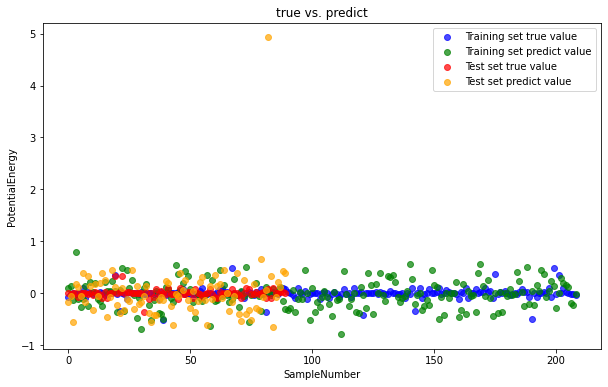


线性回归:
训练集平均绝对百分比误差:2.636
测试集平均绝对百分比误差:7.397
平均绝对误差: 0.0689955763952934
r2_score -0.5148395028629102


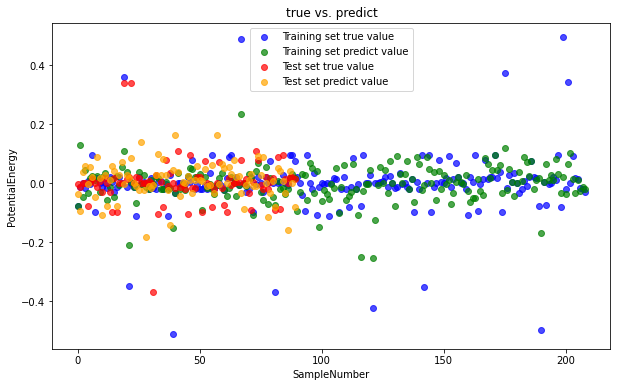


决策树回归:
训练集平均绝对百分比误差:nan
测试集平均绝对百分比误差:nan
平均绝对误差: 0.07831403904909498
r2_score -1.6141540403733017


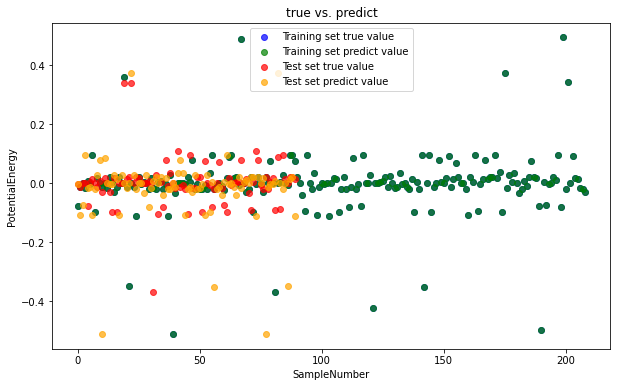


随机森林回归:
训练集平均绝对百分比误差:2.153
测试集平均绝对百分比误差:7.290
平均绝对误差: 0.06589341422306973
r2_score -0.45909492075000635


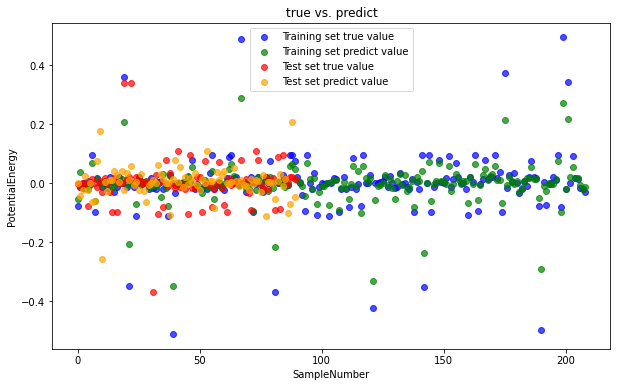


Adaboost回归:
训练集平均绝对百分比误差:inf
测试集平均绝对百分比误差:3.989
平均绝对误差: 0.07664608276359686
r2_score -0.9936410071554573


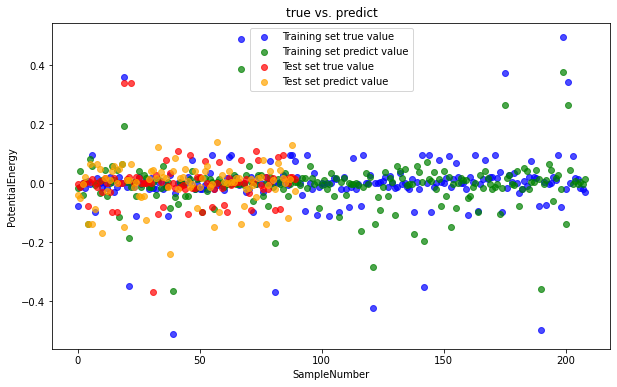


GBDT回归:
训练集平均绝对百分比误差:3.106
测试集平均绝对百分比误差:6.946
平均绝对误差: 0.030487306222357367
r2_score 0.7190238174598443


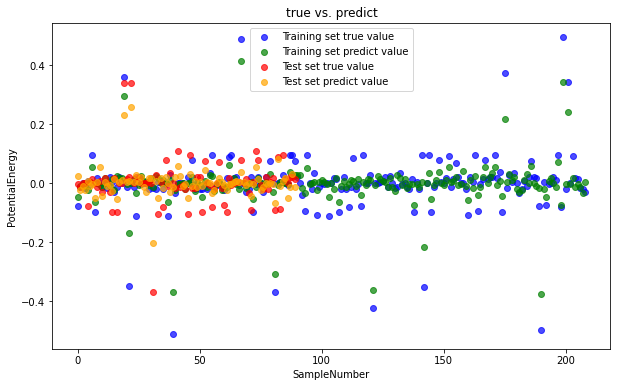


xgboost回归:
训练集平均绝对百分比误差:0.212
测试集平均绝对百分比误差:0.338
平均绝对误差: 0.0008717796969309605
r2_score 0.9997310325558236


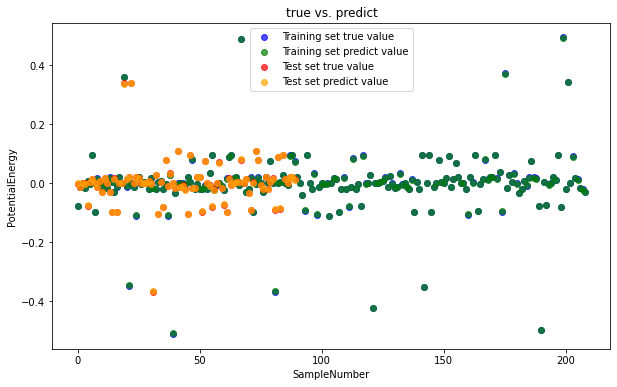

In [26]:




model=MLPRegressor(hidden_layer_sizes=10,max_iter=1000).fit(tr_x,tr_y)
y_pred=model.predict(te_x)

print("神经网络:")
print("训练集平均绝对百分比误差:{:.3f}".format(mape(model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))


# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()



print("\n线性回归:")
logreg = LinearRegression()
logreg.fit(tr_x, tr_y)
y_pred = logreg.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(logreg.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(logreg.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = logreg.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = logreg.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

      
print("\n决策树回归:")
tree=DecisionTreeRegressor(max_depth=50,random_state=0)
tree.fit(tr_x,tr_y)
y_pred = tree.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = tree.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = tree.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()
      
      
print("\n随机森林回归:")
rf=RandomForestRegressor()
rf.fit(tr_x,tr_y)

y_pred = rf.predict(te_x)

print("训练集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = rf.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = rf.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()
      

# print("\nLGBM回归:")
# lgb_model=lgb.LGBMRegressor()
# lgb_model.fit(tr_x,tr_y)
# y_pred = lgb_model.predict(te_x)
# print("训练集平均绝对百分比误差:{:.3f}".format(mape(lgb_model.predict(tr_x),tr_y)))
# print("测试集平均绝对百分比误差:{:.3f}".format(mape(lgb_model.predict(te_x),te_y)))
# print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
# print("r2_score",r2_score(te_y,y_pred))

# # 真实值与拟合值的对比图
# plt.figure(figsize=(10, 6))

# # 训练集
# tr_y_pred = lgb_model.predict(tr_x)
# plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
# plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# # 测试集
# te_y_pred = lgb_model.predict(te_x)
# plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
# plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# # 为图添加标题和图例
# plt.title('真实值 vs. 预测值')
# plt.xlabel('样本序号')
# plt.ylabel('综合得分')
# plt.legend()
# # 显示图形
# plt.show()

print("\nAdaboost回归:")
# 构建Adaboost回归模型
ada_model = AdaBoostRegressor(n_estimators=100)
ada_model.fit(tr_x,tr_y)
y_pred = ada_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(ada_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(ada_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = ada_model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = ada_model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

print("\nGBDT回归:")
# 构建GBDT回归模型
gbdt_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
gbdt_model.fit(X, Y)
y_pred = gbdt_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(gbdt_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(gbdt_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = gbdt_model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = gbdt_model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

print("\nxgboost回归:")
# 构建xgboost回归模型
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, Y)

y_pred = xgb_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = xgb_model.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = xgb_model.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()



xgboost回归:
训练集平均绝对百分比误差:0.000
平均绝对误差: 0.010402661614071954
r2_score 0.97615940834789


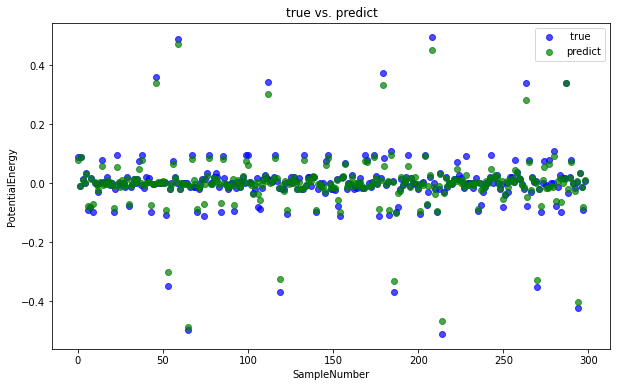

In [27]:
print("\nxgboost回归:")
# 构建xgboost回归模型
xgb_model = xgb.XGBRegressor(n_estimators=31,max_depth=6)
xgb_model.fit(X,Y)
y_pred = xgb_model.predict(X)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(X),y_pred)))
print("平均绝对误差:",mean_absolute_error(Y, y_pred))
print("r2_score",r2_score(Y,y_pred))

plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = xgb_model.predict(tr_x)
plt.scatter(list(range(X.shape[0])), Y, color='blue', label=' true', alpha=0.7)
plt.scatter(list(range(X.shape[0])), y_pred, color='green', label='predict', alpha=0.7)

# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()




In [28]:
#conda install -c conda-forge shap

In [29]:
import shap

In [30]:
import shap
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)


# 计算SHAP值
shap_values = explainer(X)

In [31]:
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

In [32]:
# 输出每个特征的SHAP值（绝对值）
features=[]
abs_mean_shap_values=[]
for i, feature in enumerate(X.columns):
    abs_mean_shap_value = np.abs(shap_df.values[:, i]).mean()
    features.append(feature)
    abs_mean_shap_values.append(abs_mean_shap_value)


In [33]:
tt=pd.DataFrame(features,columns=['features'])
tt['shap_values']=abs_mean_shap_values

In [34]:
tt1=pd.read_csv('tt.csv')
tt1

features            classify
0           p1_score_0            p1_score
1           p1_score_1            p1_score
2          p1_score_15            p1_score
3           p1_score_2            p1_score
4           p1_score_3            p1_score
..                 ...                 ...
64  p2_break_pt_missed  p2_break_pt_missed
65     p1_distance_run     p1_distance_run
66     p2_distance_run     p2_distance_run
67         rally_count         rally_count
68           speed_mph           speed_mph

[69 rows x 2 columns]

In [35]:
tt['classify']=tt1['classify']

In [36]:
tt

features  shap_values            classify
0           p1_score_0     0.000248            p1_score
1           p1_score_1     0.000000            p1_score
2          p1_score_15     0.002167            p1_score
3           p1_score_2     0.000249            p1_score
4           p1_score_3     0.000033            p1_score
..                 ...          ...                 ...
64  p2_break_pt_missed     0.001875  p2_break_pt_missed
65     p1_distance_run     0.011499     p1_distance_run
66     p2_distance_run     0.013680     p2_distance_run
67         rally_count     0.004345         rally_count
68           speed_mph     0.008425           speed_mph

[69 rows x 3 columns]

In [37]:
a=tt.groupby('classify').sum()
a

shap_values
classify                       
game_no                0.008869
game_victor            0.002594
p1_ace                 0.000046
p1_break_pt            0.000000
p1_break_pt_missed     0.000000
p1_break_pt_won        0.000000
p1_distance_run        0.011499
p1_double_fault        0.000565
p1_games               0.002667
p1_net_pt              0.001847
p1_net_pt_won          0.000343
p1_points_won          0.000000
p1_score               0.005845
p1_sets                0.000000
p1_unf_err             0.000000
p1_winner              0.002669
p2_ace                 0.001150
p2_break_pt            0.000000
p2_break_pt_missed     0.001875
p2_break_pt_won        0.000000
p2_distance_run        0.013680
p2_double_fault        0.000256
p2_games               0.000620
p2_net_pt              0.000313
p2_net_pt_won          0.000000
p2_points_won          0.000000
p2_score               0.008511
p2_sets                0.000000
p2_unf_err             0.001506
p2_winner              0.001884
point_no               0.007063
point_victor           0.002284
rally_count            0.004345
serve_depth            0.001569
serve_no               0.000188
serve_width            0.007324
server                 0.002879
set_no                 0.000680
set_victor             0.000000
speed_mph              0.008425
winner_shot_type       0.001681

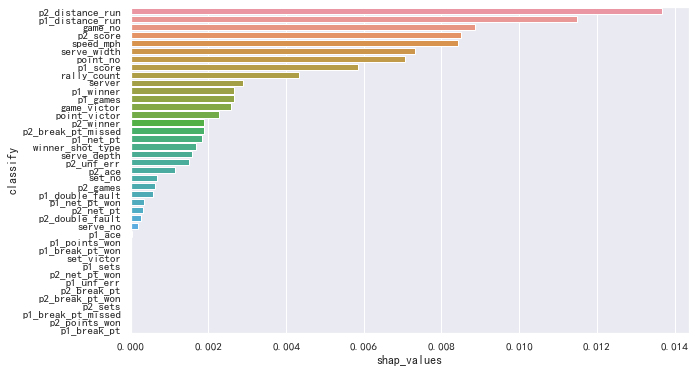

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.rcParams['font.sans-serif'] = ['SimHei']  
# Matplotlib中设置字体-黑体，解决Matplotlib中文乱码问题
plt.rcParams['axes.unicode_minus'] = False    
# 解决Matplotlib坐标轴负号'-'显示为方块的问题
sns.set(font='SimHei')                        
# Seaborn中设置字体-黑体，解决Seaborn中文乱码问题
a_sorted = a.sort_values(by='shap_values', ascending=False)

# 设置图表大小，例如设置为宽10英寸，高6英寸
plt.figure(figsize=(10, 6))
# 使用Seaborn绘制柱状图
sns.barplot(x='shap_values', y='classify', data=a_sorted.reset_index(), orient='h')
plt.savefig('classify')
# 显示图形
plt.show()
#特征重要度

In [39]:

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)

shap.initjs() #初始化JS
shap_values = explainer.shap_values(X) #计算每个样本的每个特征的SHAP值

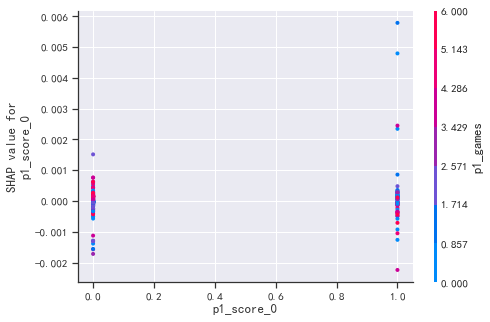

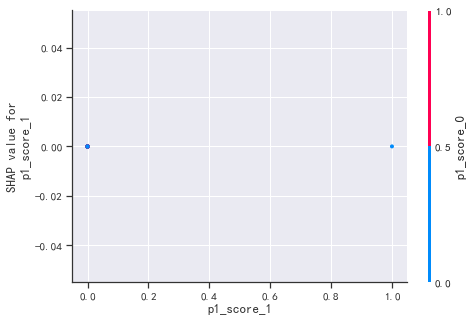

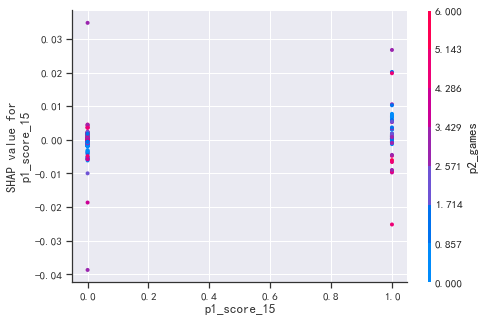

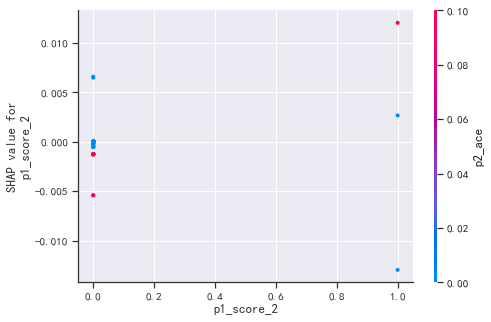

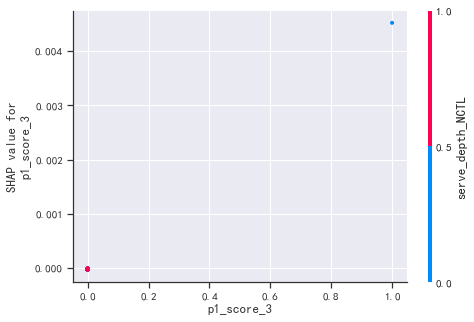

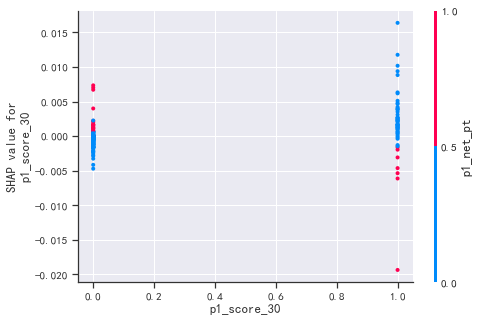

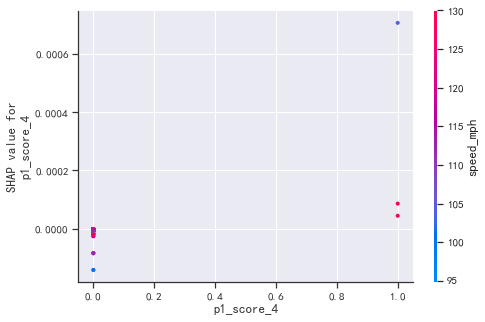

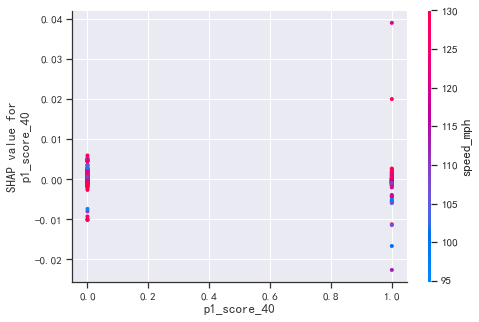

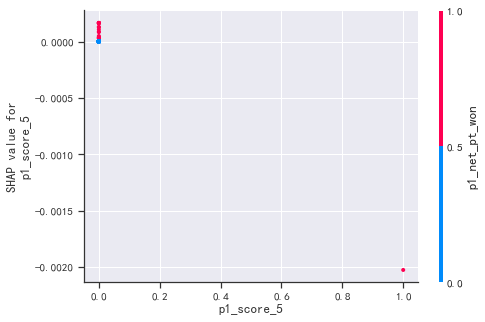

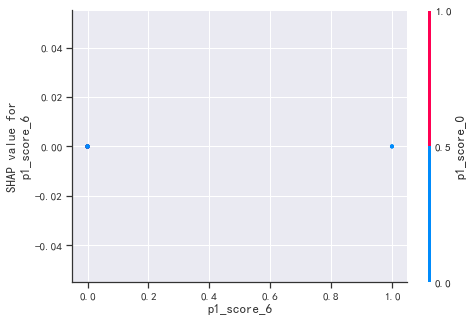

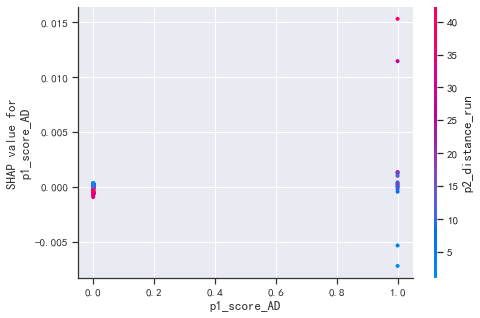

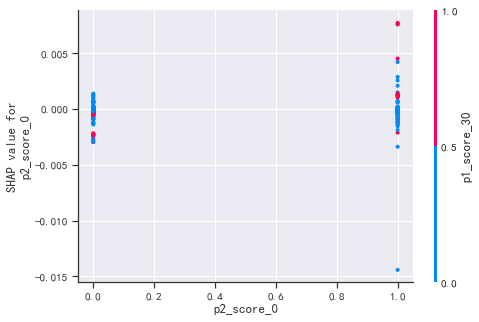

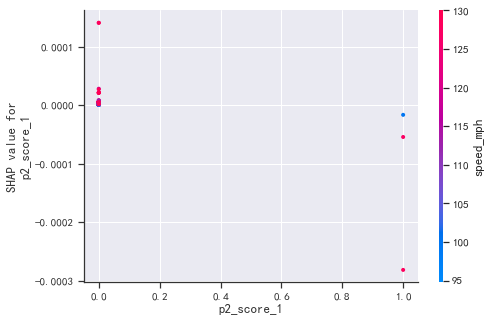

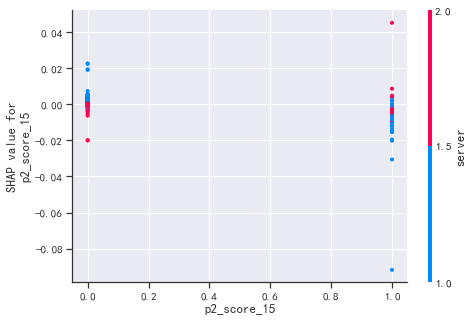

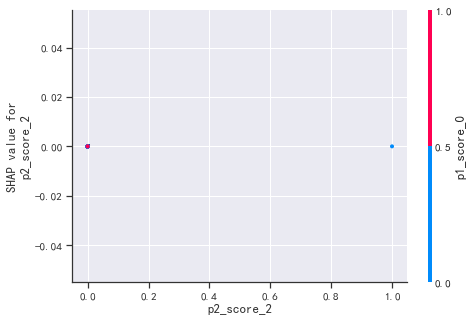

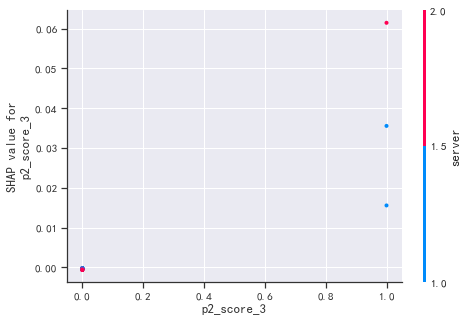

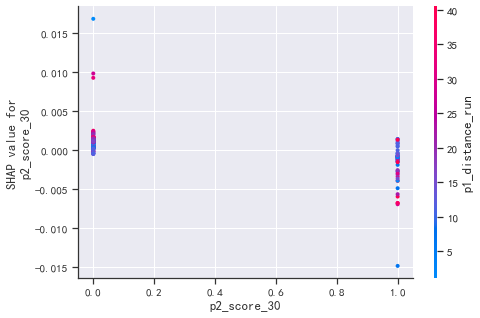

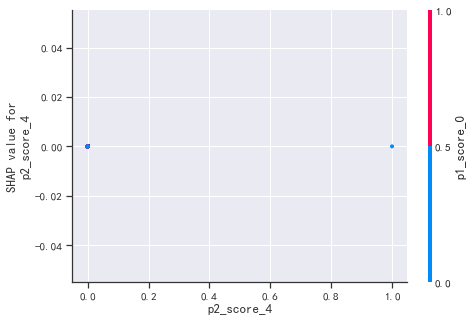

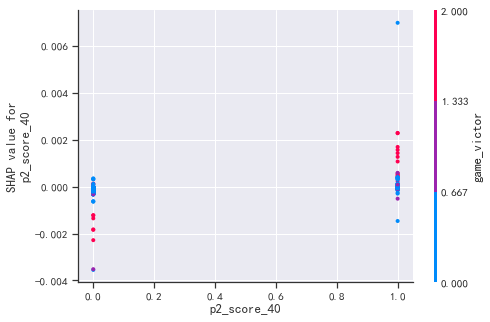

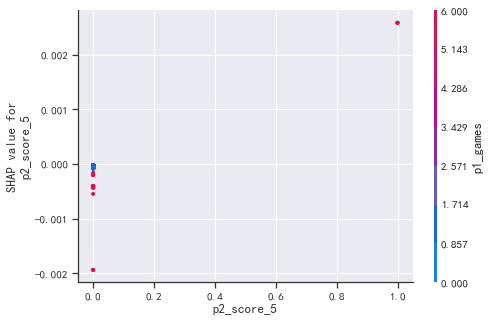

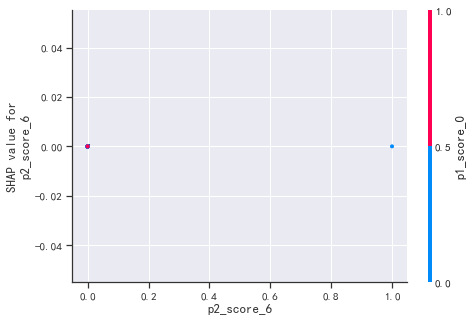

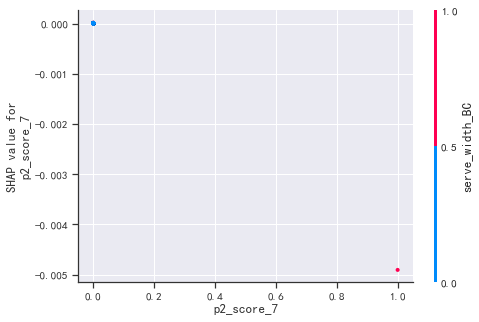

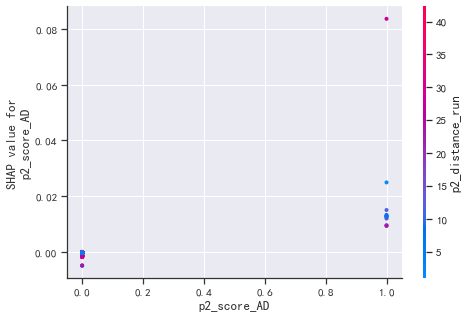

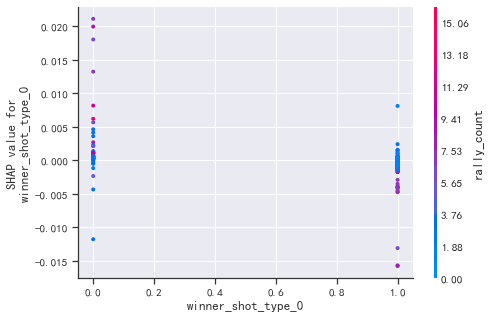

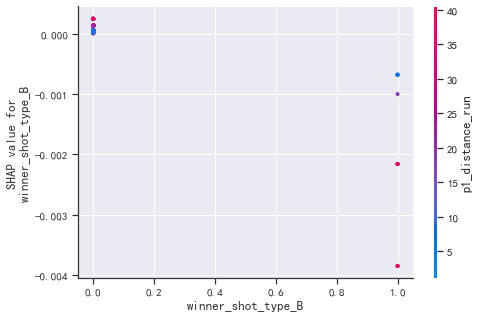

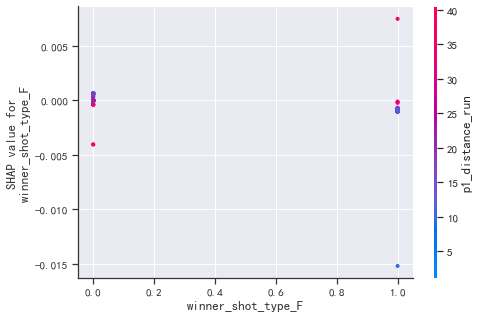

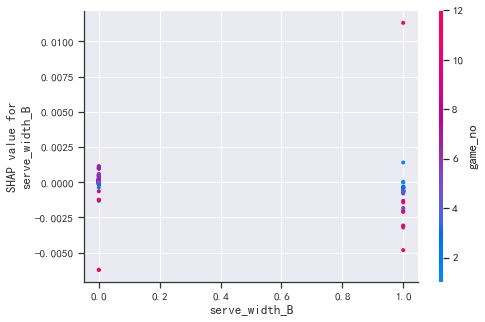

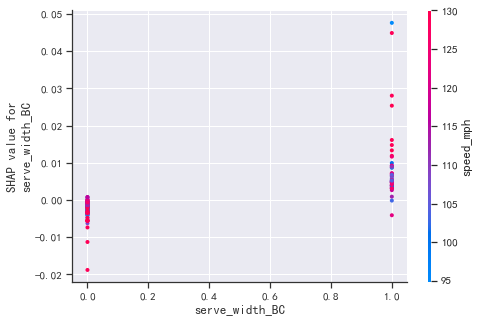

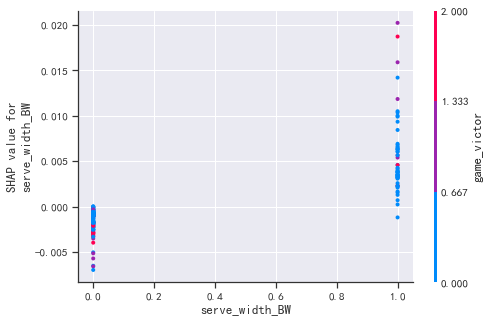

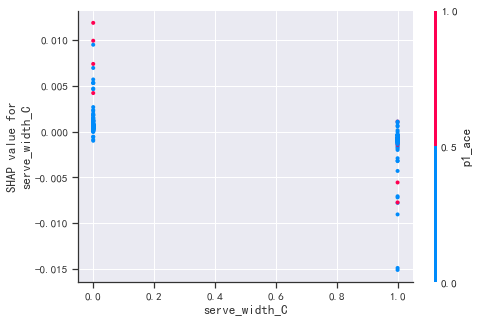

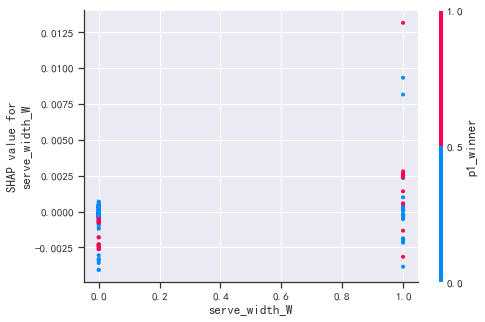

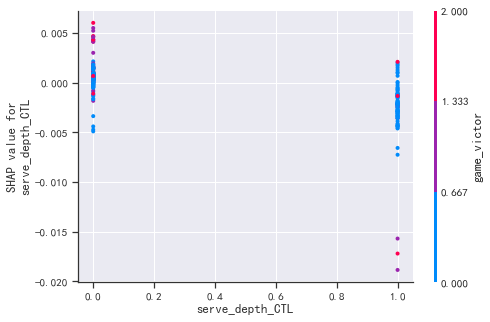

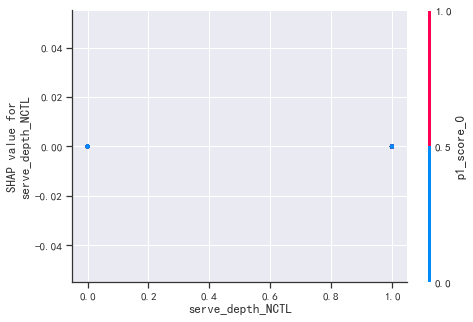

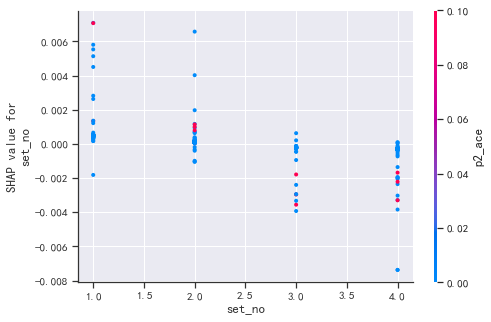

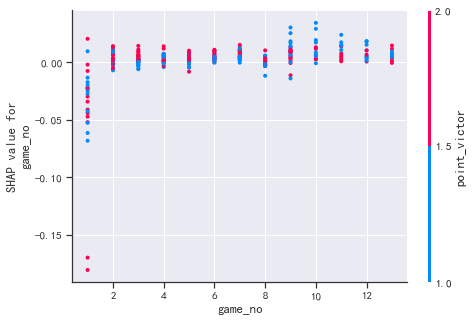

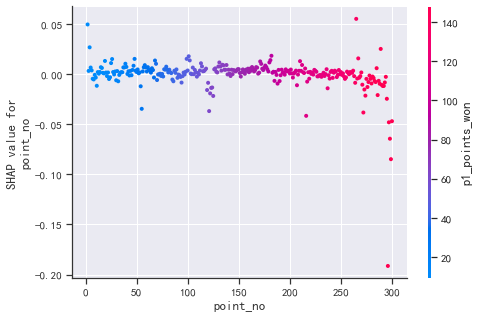

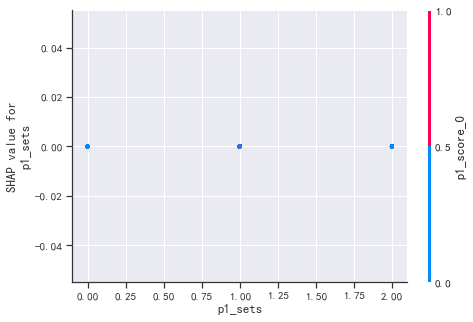

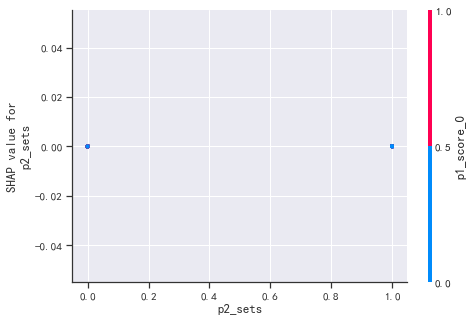

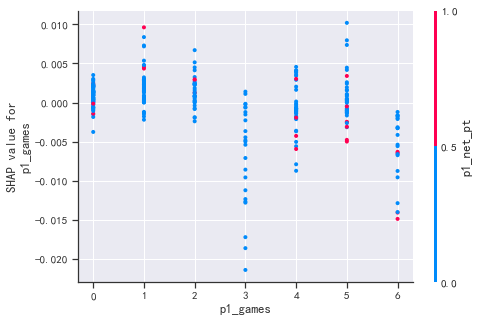

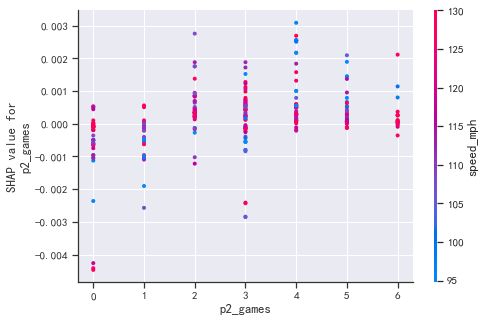

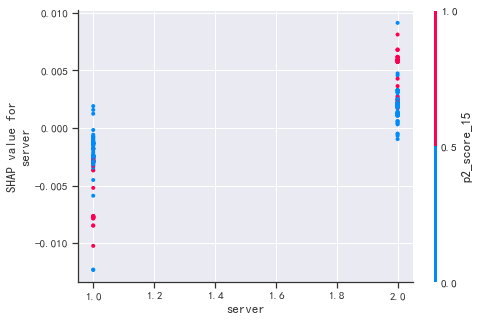

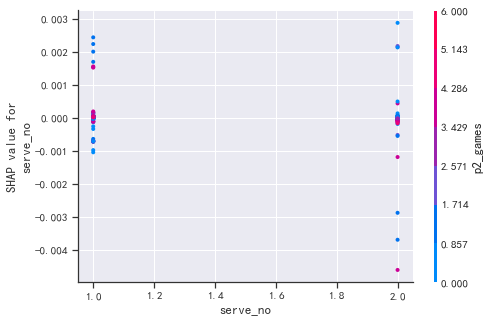

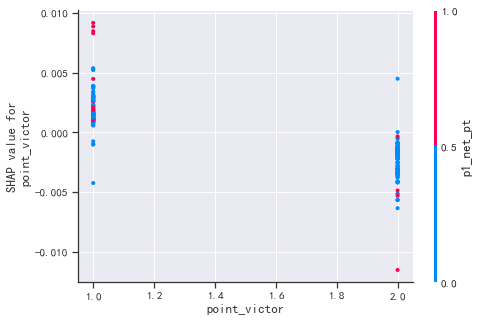

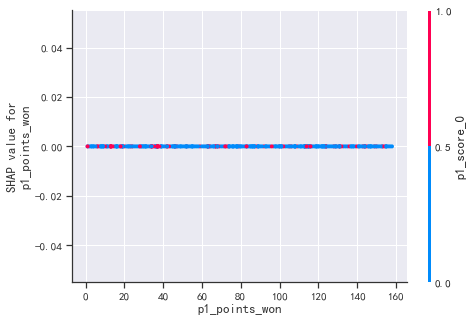

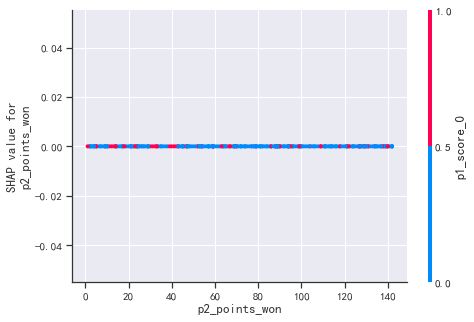

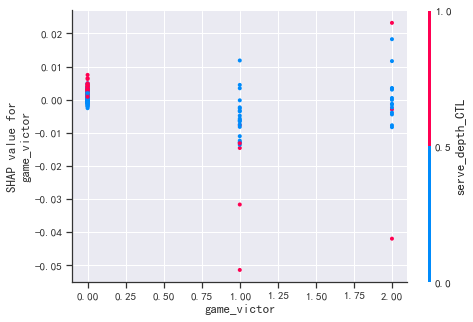

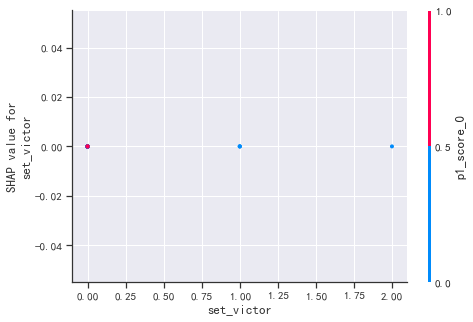

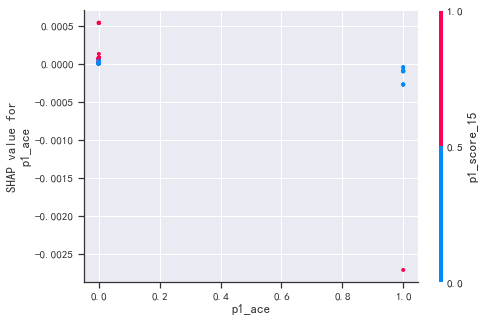

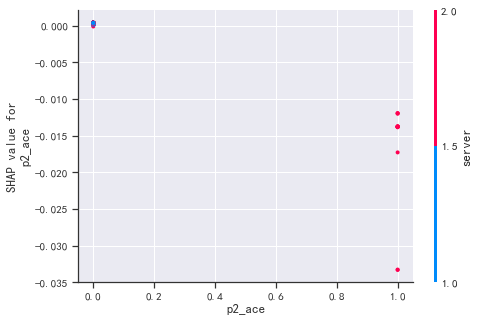

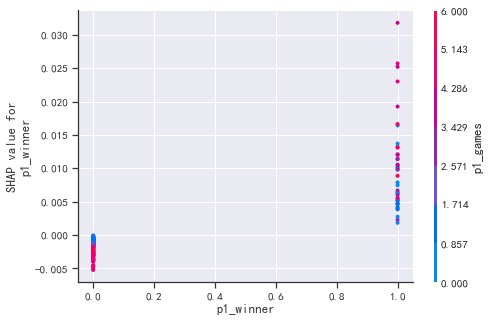

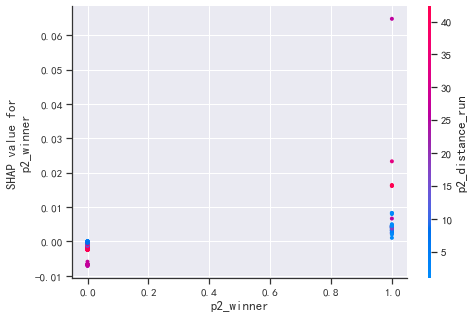

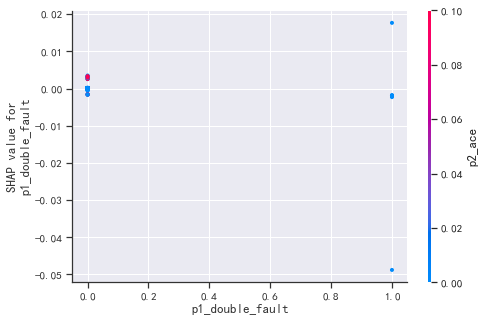

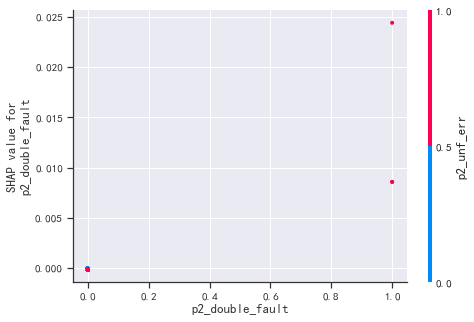

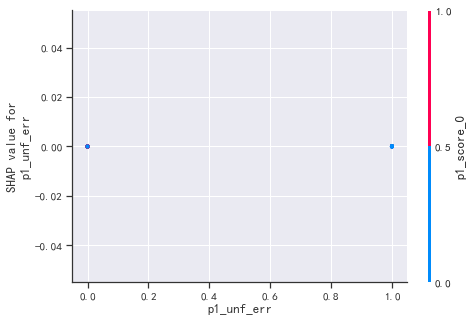

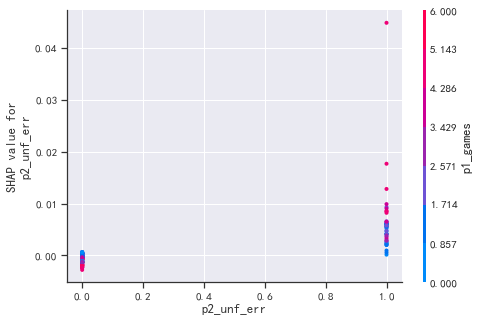

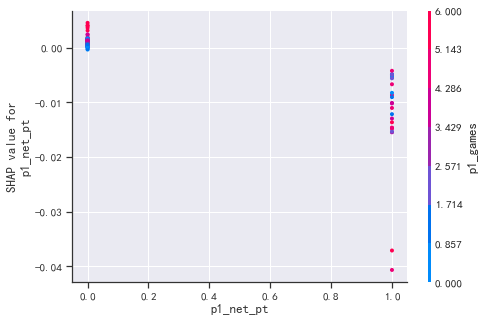

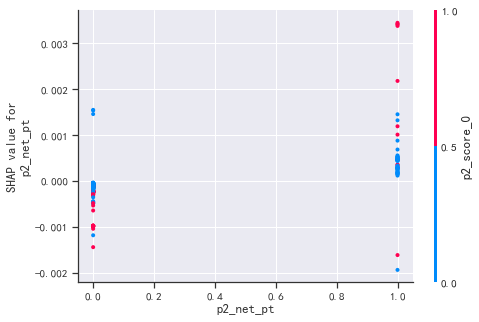

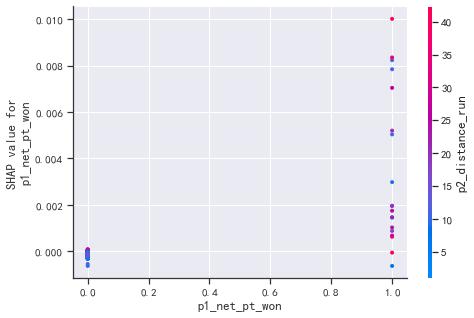

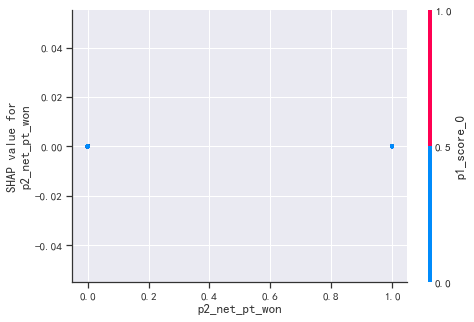

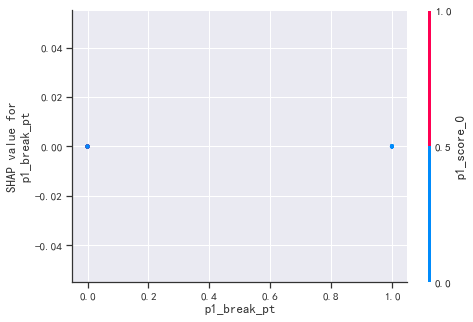

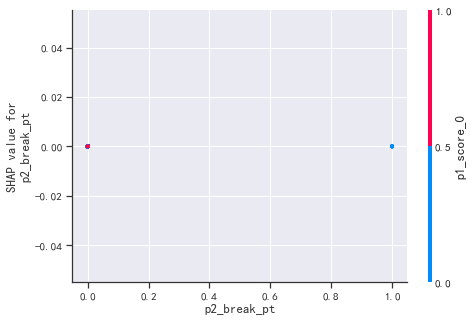

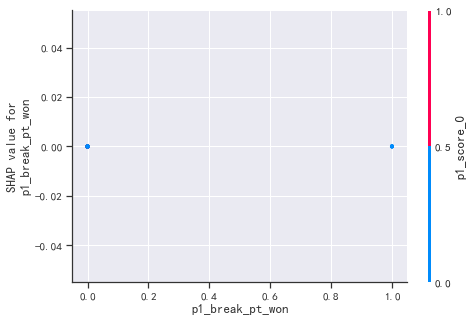

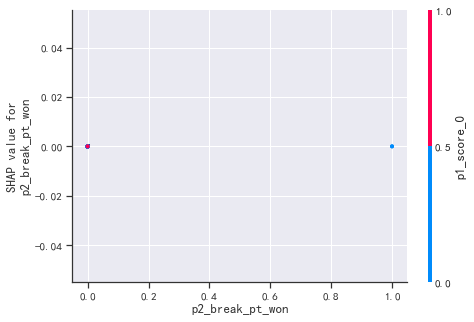

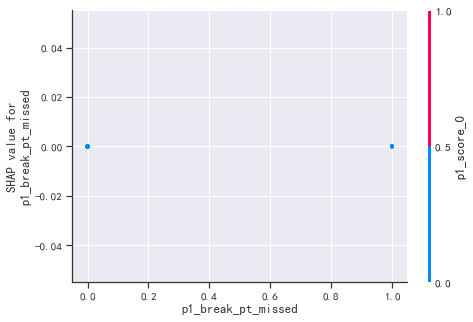

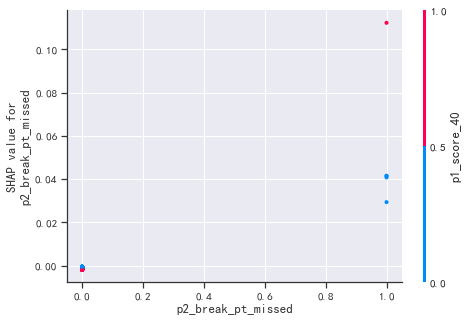

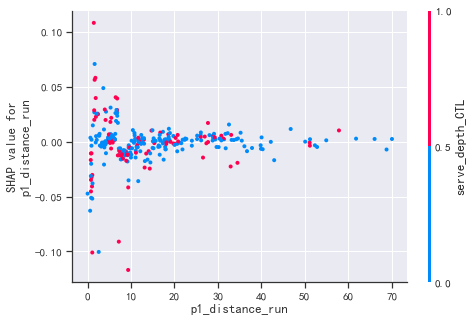

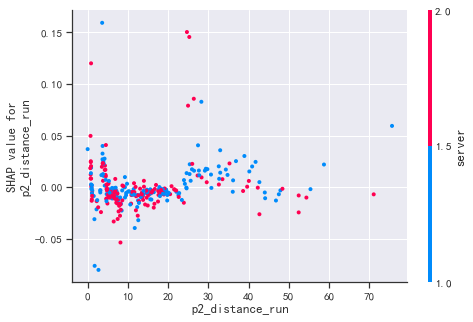

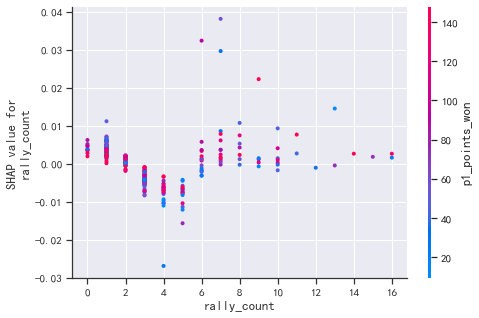

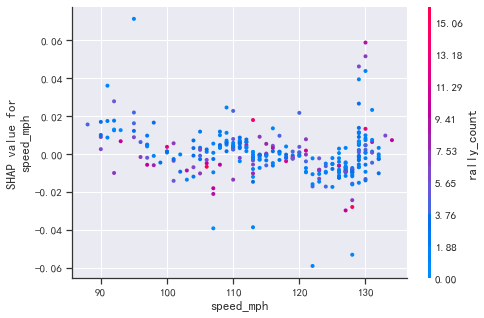

In [40]:
for i in X.columns:
    shap.dependence_plot(i, shap_values, X)

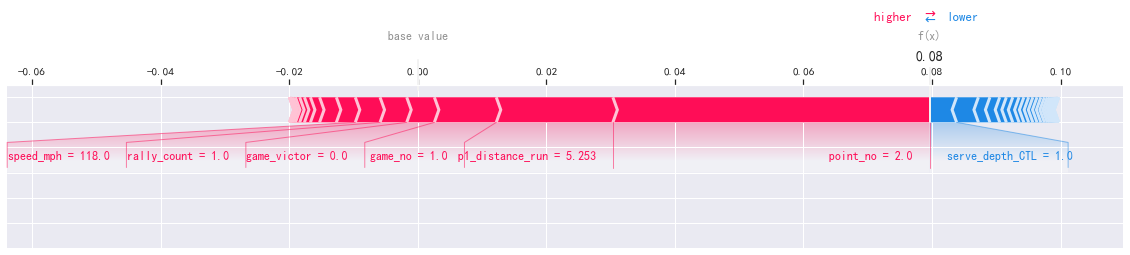

In [42]:
i=0
shap.force_plot(explainer.expected_value, shap_values[i,:], data[X.columns].iloc[i,:],matplotlib=True) #3860为样本在数据集中的索引

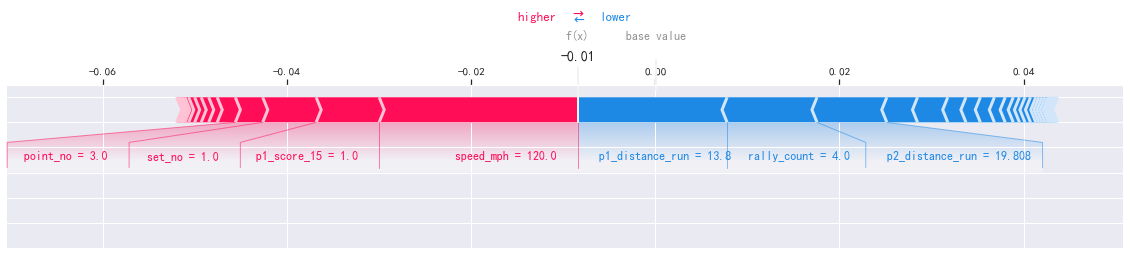

In [44]:
i=1
shap.force_plot(explainer.expected_value, shap_values[i,:], data[X.columns].iloc[i,:],matplotlib=True) #3860为样本在数据集中的索引

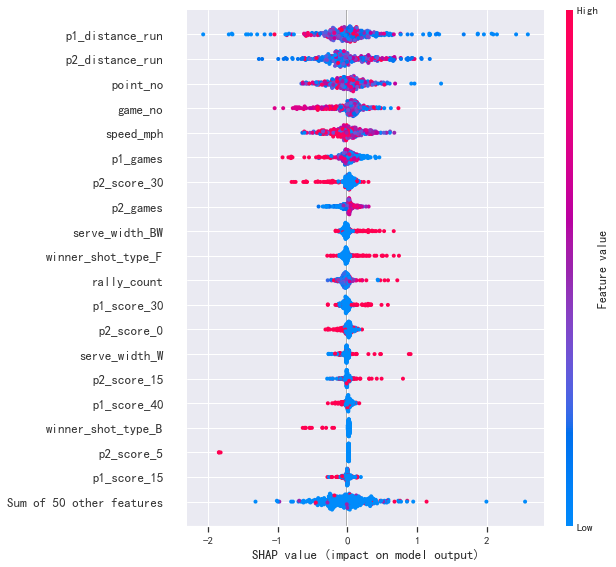

In [83]:
shap.plots.beeswarm(explainer(X),max_display=20)

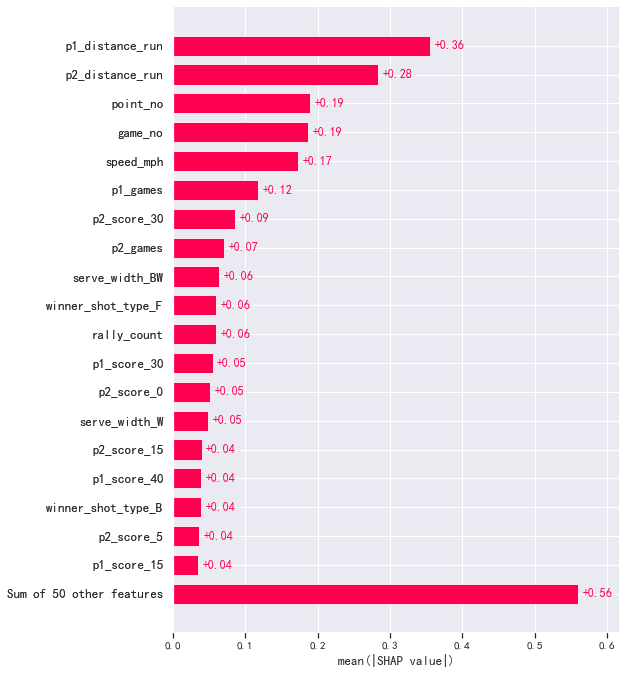

In [84]:
shap.plots.bar(explainer(X),max_display=20)

In [45]:
shap.force_plot(explainer.expected_value, shap_values, X, link="logit")

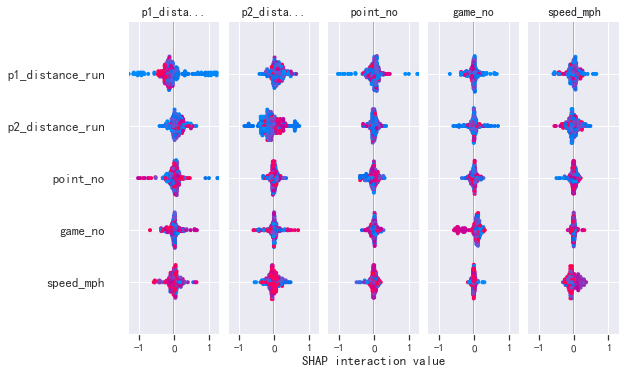

In [86]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X,max_display=5)

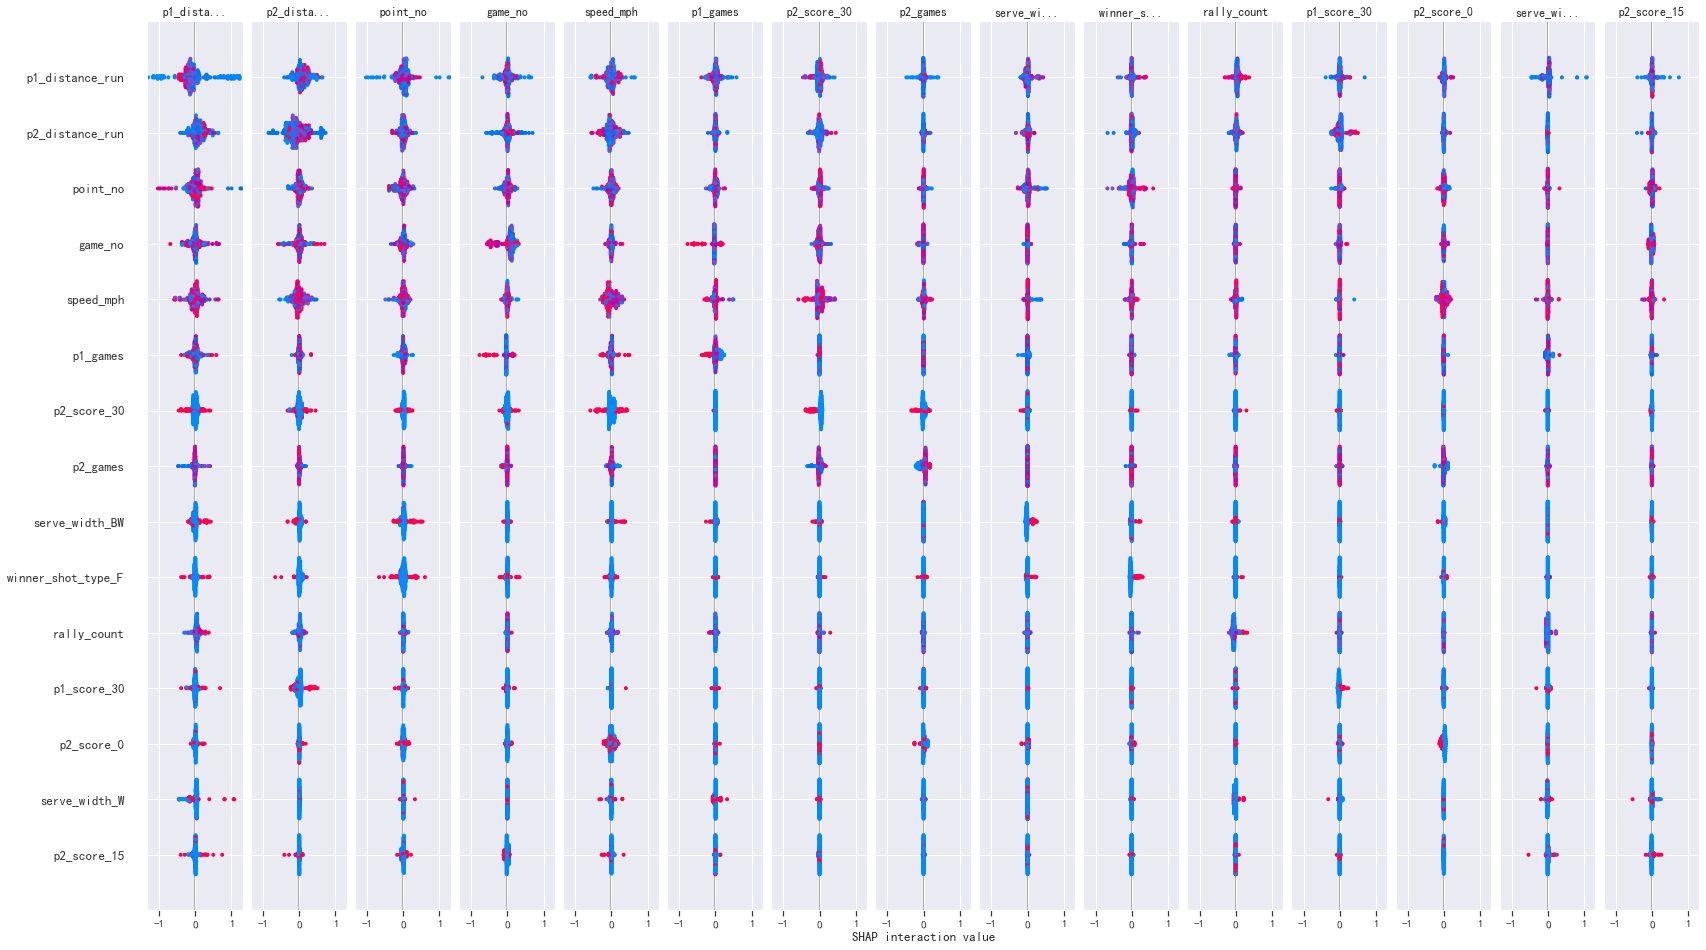

In [87]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X,max_display=15)